In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import json

In [20]:
# Cek ketersediaan GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


In [21]:
with open("DeteksiSarkasme.json", 'r') as f:
     data = [json.loads(line) for line in f]

df = pd.DataFrame(data)
df = df[['headline', 'is_sarcastic']].dropna()

print("Label Distribution:\n", df['is_sarcastic'].value_counts())

Label Distribution:
 is_sarcastic
0    14985
1    11724
Name: count, dtype: int64


In [22]:
# Tokenisasi dan preprocessing teks
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(df['headline'])
X = tokenizer.texts_to_sequences(df['headline'])
X = pad_sequences(X, maxlen=30, padding='post')
y = df['is_sarcastic'].values

In [23]:
# Split data menjadi training dan testing
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [24]:
# Konversi ke tensor PyTorch
x_train_tensor = torch.tensor(x_train, dtype=torch.long)
x_test_tensor = torch.tensor(x_test, dtype=torch.long)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

In [25]:
# Buat dataset dan dataloader PyTorch
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128)

In [26]:
# Hitung positive weight untuk menangani ketidakseimbangan kelas
pos_weight_val = (len(y_train) - y_train.sum()) / y_train.sum()
pos_weight = torch.tensor([pos_weight_val]).to(device)

In [27]:
# Model 1: Bidirectional RNN
class SarcasmRNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim):
        super(SarcasmRNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.RNN(embedding_dim, hidden_dim, num_layers=2, batch_first=True,
                          bidirectional=True, nonlinearity='relu')
        self.fc1 = nn.Linear(hidden_dim * 2, 128)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, output_dim)

    def forward(self, x):
        x = self.embedding(x)
        _, h_n = self.rnn(x)
        # Gabungkan output dari kedua arah (forward & backward)
        h_n = torch.cat((h_n[-2,:,:], h_n[-1,:,:]), dim=1)
        x = torch.relu(self.fc1(h_n))
        x = self.dropout(x)
        x = self.fc2(x)
        return torch.sigmoid(x).view(-1)

In [28]:
def train_evaluate_model(model_name, model, criterion, optimizer, epochs=10):
    """Fungsi untuk melatih dan mengevaluasi model"""
    train_acc_hist, val_acc_hist, train_loss_hist, val_loss_hist = [], [], [], []

    for epoch in range(epochs):
        # Training
        model.train()
        total_loss, correct = 0, 0
        for x_batch, y_batch in train_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(x_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            preds = (outputs >= 0.5).float()
            correct += (preds == y_batch).sum().item()

        train_acc = correct / len(train_dataset)
        train_loss = total_loss / len(train_loader)
        train_acc_hist.append(train_acc)
        train_loss_hist.append(train_loss)

        # Validation
        model.eval()
        val_loss, val_correct = 0, 0
        with torch.no_grad():
            for x_batch, y_batch in test_loader:
                x_batch, y_batch = x_batch.to(device), y_batch.to(device)
                outputs = model(x_batch)
                loss = criterion(outputs, y_batch)
                val_loss += loss.item()
                preds = (outputs >= 0.5).float()
                val_correct += (preds == y_batch).sum().item()

        val_acc = val_correct / len(test_dataset)
        val_loss_hist.append(val_loss / len(test_loader))
        val_acc_hist.append(val_acc)

        print(f"Epoch {epoch+1}/{epochs} | Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")

    # Evaluasi model
    model.eval()
    y_probs = []
    with torch.no_grad():
        for x_batch, _ in test_loader:
            x_batch = x_batch.to(device)
            outputs = model(x_batch)
            y_probs.extend(outputs.cpu().numpy())

    y_probs = np.array(y_probs)
    y_preds = (y_probs >= 0.5).astype(int)

    # Hitung metrik evaluasi
    acc = accuracy_score(y_test, y_preds)
    precision = precision_score(y_test, y_preds)
    recall = recall_score(y_test, y_preds)
    f1_sq = f1_score(y_test, y_preds) ** 2  # F1 Squared
    auc = roc_auc_score(y_test, y_probs)

    # Cetak hasil evaluasi
    print(f"\n{model_name} Results:")
    print(f"Final Training Accuracy: {train_acc_hist[-1]:.4f}")
    print(f"Final Testing Accuracy: {acc:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Squared: {f1_sq:.4f}")
    print(f"AUC: {auc:.4f}")

    # Plot ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_probs)
    plt.figure()
    plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc:.4f})')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {model_name}')
    plt.legend()
    plt.grid()
    plt.show()

    # Plot accuracy dan loss history
    plt.figure(figsize=(10, 4))

    plt.subplot(1, 2, 1)
    plt.plot(train_acc_hist, label='Train Acc', marker='o')
    plt.plot(val_acc_hist, label='Val Acc', marker='s')
    plt.title(f'{model_name} Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_loss_hist, label='Train Loss', marker='o')
    plt.plot(val_loss_hist, label='Val Loss', marker='s')
    plt.title(f'{model_name} Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

    return {
        'accuracy': acc,
        'precision': precision,
        'recall': recall,
        'f1_squared': f1_sq,
        'auc': auc,
        'train_acc_hist': train_acc_hist,
        'val_acc_hist': val_acc_hist,
        'train_loss_hist': train_loss_hist,
        'val_loss_hist': val_loss_hist
    }


Training RNN model...
Epoch 1/10 | Train Acc: 0.5611, Val Acc: 0.5608
Epoch 2/10 | Train Acc: 0.5611, Val Acc: 0.5608
Epoch 3/10 | Train Acc: 0.5611, Val Acc: 0.5608
Epoch 4/10 | Train Acc: 0.5611, Val Acc: 0.5608
Epoch 5/10 | Train Acc: 0.5611, Val Acc: 0.5608
Epoch 6/10 | Train Acc: 0.5611, Val Acc: 0.5608
Epoch 7/10 | Train Acc: 0.5611, Val Acc: 0.5608
Epoch 8/10 | Train Acc: 0.5611, Val Acc: 0.5608
Epoch 9/10 | Train Acc: 0.5611, Val Acc: 0.5608
Epoch 10/10 | Train Acc: 0.5611, Val Acc: 0.5608

RNN Results:
Final Training Accuracy: 0.5611
Final Testing Accuracy: 0.5608
Precision: 0.0000
Recall: 0.0000
F1 Squared: 0.0000
AUC: 0.5000


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


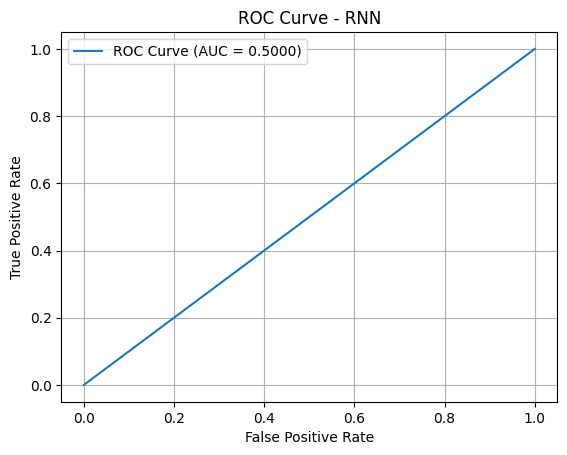

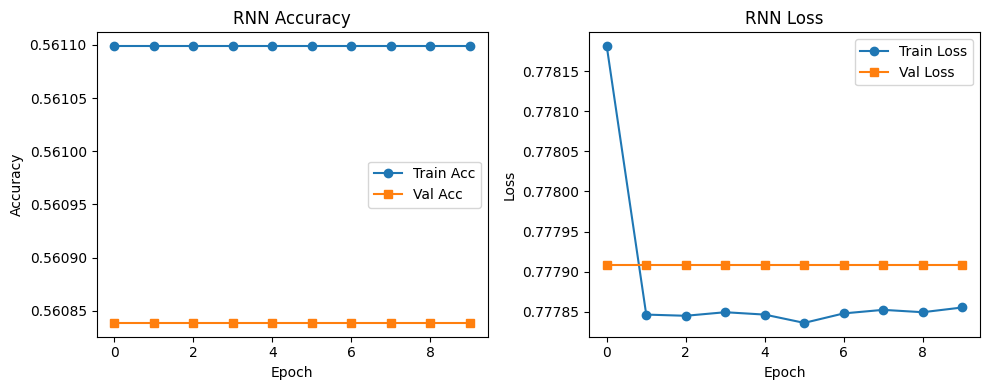

In [30]:
# Inisialisasi dan train model RNN
vocab_size = len(tokenizer.word_index) + 1
rnn_model = SarcasmRNN(vocab_size, embedding_dim=128, hidden_dim=256, output_dim=1).to(device)
rnn_criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
rnn_optimizer = optim.Adam(rnn_model.parameters(), lr=0.0005)

print("\nTraining RNN model...")
rnn_results = train_evaluate_model("RNN", rnn_model, rnn_criterion, rnn_optimizer, epochs=10)

In [31]:
# Model 2: LSTM
class SarcasmLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim):
        super(SarcasmLSTM, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.fc1 = nn.Linear(hidden_dim * 2, 128)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, output_dim)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.embedding(x)
        _, (h_n, _) = self.lstm(x)
        h_n = torch.cat((h_n[-2,:,:], h_n[-1,:,:]), dim=1)
        x = torch.relu(self.fc1(h_n))
        x = self.dropout(x)
        x = self.sigmoid(self.fc2(x))
        return x.view(-1)


Training LSTM model...
Epoch 1/10 | Train Acc: 0.7516, Val Acc: 0.8100
Epoch 2/10 | Train Acc: 0.8642, Val Acc: 0.8390
Epoch 3/10 | Train Acc: 0.9184, Val Acc: 0.8476
Epoch 4/10 | Train Acc: 0.9546, Val Acc: 0.8527
Epoch 5/10 | Train Acc: 0.9781, Val Acc: 0.8426
Epoch 6/10 | Train Acc: 0.9897, Val Acc: 0.8443
Epoch 7/10 | Train Acc: 0.9927, Val Acc: 0.8426
Epoch 8/10 | Train Acc: 0.9960, Val Acc: 0.8486
Epoch 9/10 | Train Acc: 0.9943, Val Acc: 0.8491
Epoch 10/10 | Train Acc: 0.9966, Val Acc: 0.8512

LSTM Results:
Final Training Accuracy: 0.9966
Final Testing Accuracy: 0.8512
Precision: 0.8379
Recall: 0.8197
F1 Squared: 0.6867
AUC: 0.9241


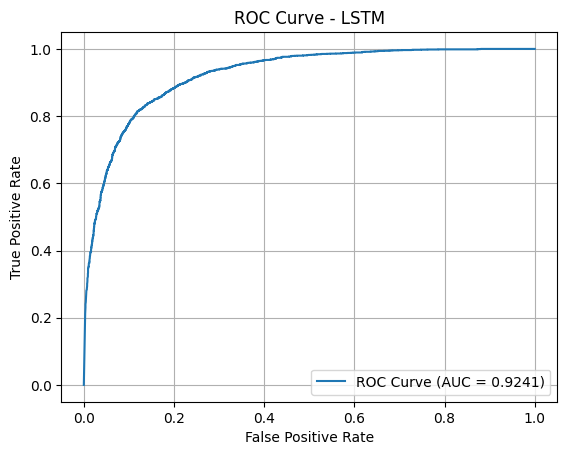

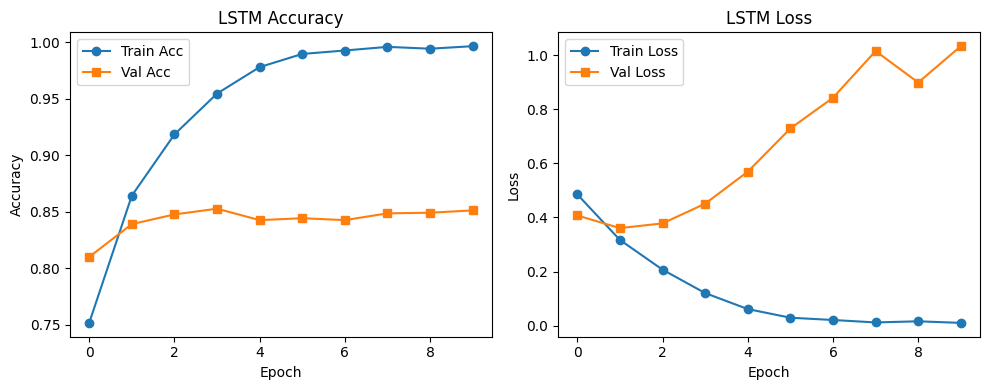

In [34]:
# Inisialisasi dan train model LSTM
lstm_model = SarcasmLSTM(vocab_size, embedding_dim=128, hidden_dim=128, output_dim=1).to(device)
lstm_criterion = nn.BCELoss()
lstm_optimizer = optim.Adam(lstm_model.parameters(), lr=0.001)

print("\nTraining LSTM model...")
lstm_results = train_evaluate_model("LSTM", lstm_model, lstm_criterion, lstm_optimizer, epochs=10)

In [35]:
# Model 3: GRU
class SarcasmGRU(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim):
        super(SarcasmGRU, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.gru = nn.GRU(embedding_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.fc1 = nn.Linear(hidden_dim * 2, 128)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, output_dim)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.embedding(x)
        _, h_n = self.gru(x)
        h_n = torch.cat((h_n[-2,:,:], h_n[-1,:,:]), dim=1)
        x = torch.relu(self.fc1(h_n))
        x = self.dropout(x)
        x = self.sigmoid(self.fc2(x))
        return x.view(-1)


Training GRU model...
Epoch 1/10 | Train Acc: 0.7447, Val Acc: 0.8057
Epoch 2/10 | Train Acc: 0.8576, Val Acc: 0.8323
Epoch 3/10 | Train Acc: 0.9109, Val Acc: 0.8422
Epoch 4/10 | Train Acc: 0.9532, Val Acc: 0.8409
Epoch 5/10 | Train Acc: 0.9792, Val Acc: 0.8452
Epoch 6/10 | Train Acc: 0.9910, Val Acc: 0.8459
Epoch 7/10 | Train Acc: 0.9935, Val Acc: 0.8487
Epoch 8/10 | Train Acc: 0.9957, Val Acc: 0.8469
Epoch 9/10 | Train Acc: 0.9963, Val Acc: 0.8469
Epoch 10/10 | Train Acc: 0.9982, Val Acc: 0.8443

GRU Results:
Final Training Accuracy: 0.9982
Final Testing Accuracy: 0.8443
Precision: 0.8441
Recall: 0.7916
F1 Squared: 0.6675
AUC: 0.9233


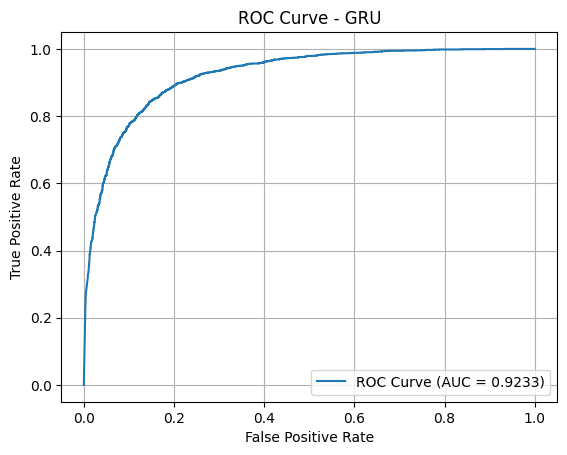

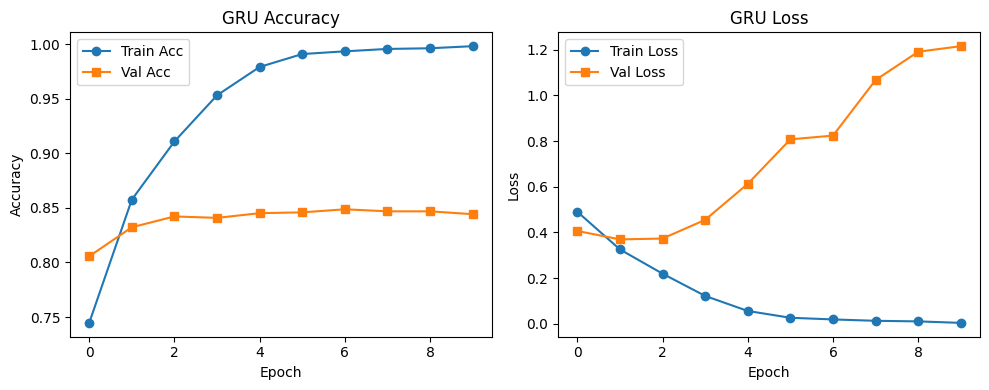

In [36]:
# Inisialisasi dan train model GRU
gru_model = SarcasmGRU(vocab_size, embedding_dim=128, hidden_dim=128, output_dim=1).to(device)
gru_criterion = nn.BCELoss()
gru_optimizer = optim.Adam(gru_model.parameters(), lr=0.001)

print("\nTraining GRU model...")
gru_results = train_evaluate_model("GRU", gru_model, gru_criterion, gru_optimizer, epochs=10)

In [37]:
# Visualisasi perbandingan semua model
def plot_comparison(rnn_results, lstm_results, gru_results):
    """Fungsi untuk memvisualisasikan perbandingan hasil model"""
    # Metric comparison
    models = ['RNN', 'LSTM', 'GRU']
    metrics = {
        'Accuracy': [rnn_results['accuracy'], lstm_results['accuracy'], gru_results['accuracy']],
        'Precision': [rnn_results['precision'], lstm_results['precision'], gru_results['precision']],
        'Recall': [rnn_results['recall'], lstm_results['recall'], gru_results['recall']],
        'F1 Squared': [rnn_results['f1_squared'], lstm_results['f1_squared'], gru_results['f1_squared']],
        'AUC': [rnn_results['auc'], lstm_results['auc'], gru_results['auc']]
    }

    plt.figure(figsize=(15, 10))
    for i, (metric_name, values) in enumerate(metrics.items(), 1):
        plt.subplot(2, 3, i)
        plt.bar(models, values, color=['blue', 'green', 'orange'])
        plt.title(f'{metric_name} Comparison')
        plt.ylim(0, 1)
        for j, v in enumerate(values):
            plt.text(j, v + 0.01, f'{v:.4f}', ha='center')

    plt.tight_layout()
    plt.show()

    # Training history comparison
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 2, 1)
    plt.plot(rnn_results['train_acc_hist'], '-o', label='RNN Train')
    plt.plot(rnn_results['val_acc_hist'], '--o', label='RNN Val')
    plt.plot(lstm_results['train_acc_hist'], '-s', label='LSTM Train')
    plt.plot(lstm_results['val_acc_hist'], '--s', label='LSTM Val')
    plt.plot(gru_results['train_acc_hist'], '-^', label='GRU Train')
    plt.plot(gru_results['val_acc_hist'], '--^', label='GRU Val')
    plt.title('Accuracy Comparison')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(rnn_results['train_loss_hist'], '-o', label='RNN Train')
    plt.plot(rnn_results['val_loss_hist'], '--o', label='RNN Val')
    plt.plot(lstm_results['train_loss_hist'], '-s', label='LSTM Train')
    plt.plot(lstm_results['val_loss_hist'], '--s', label='LSTM Val')
    plt.plot(gru_results['train_loss_hist'], '-^', label='GRU Train')
    plt.plot(gru_results['val_loss_hist'], '--^', label='GRU Val')
    plt.title('Loss Comparison')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()


Visualisasi perbandingan model...


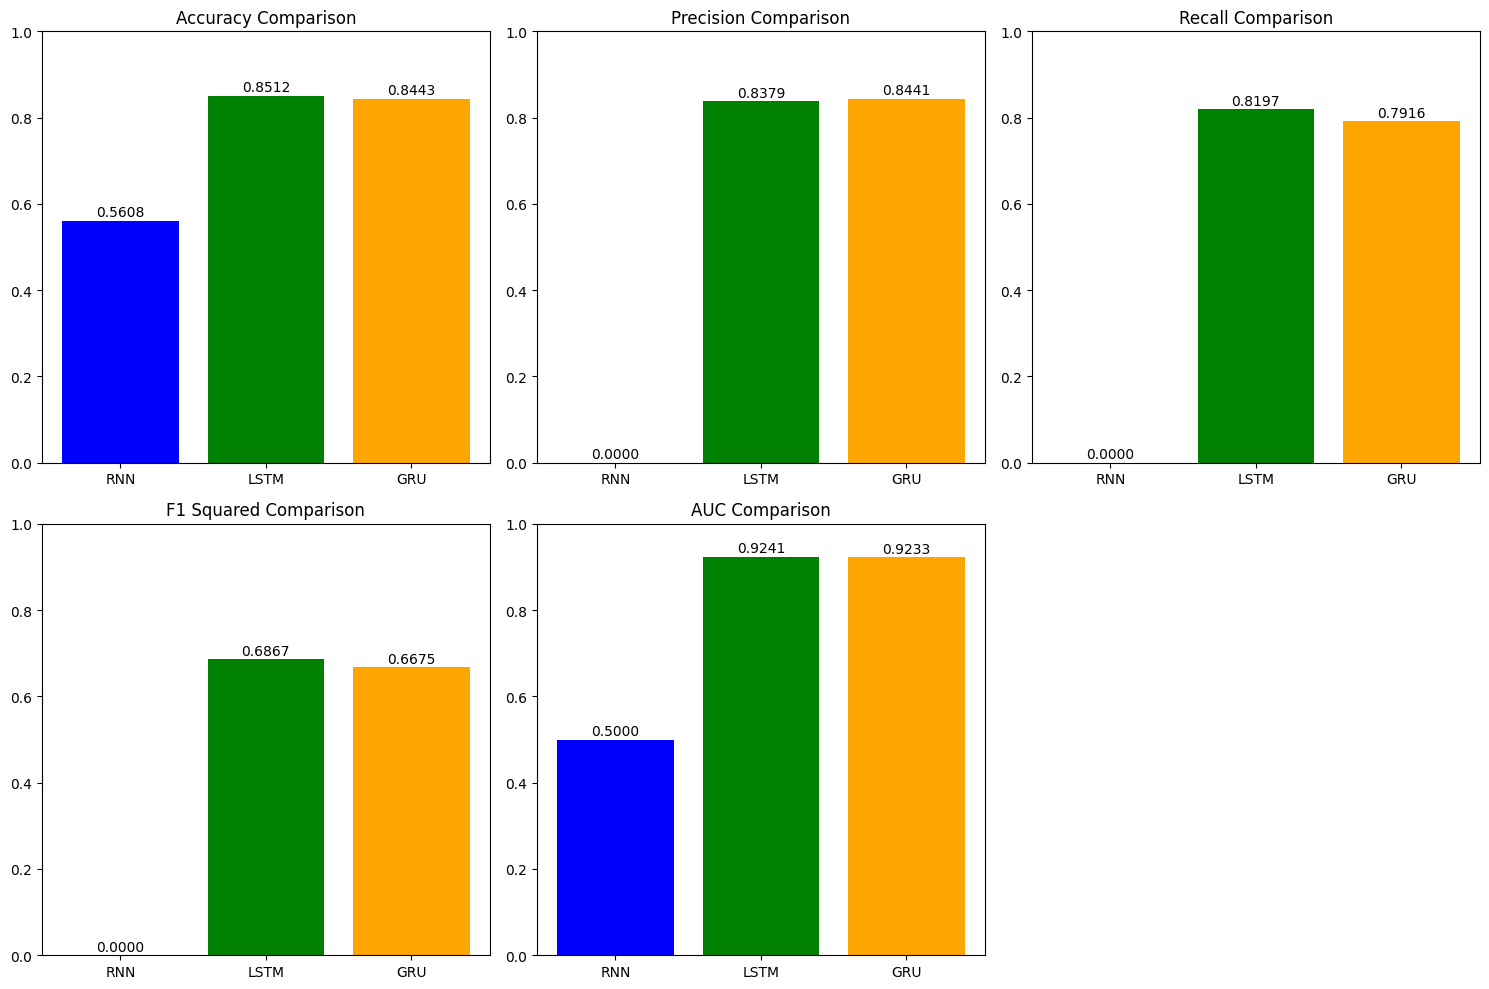

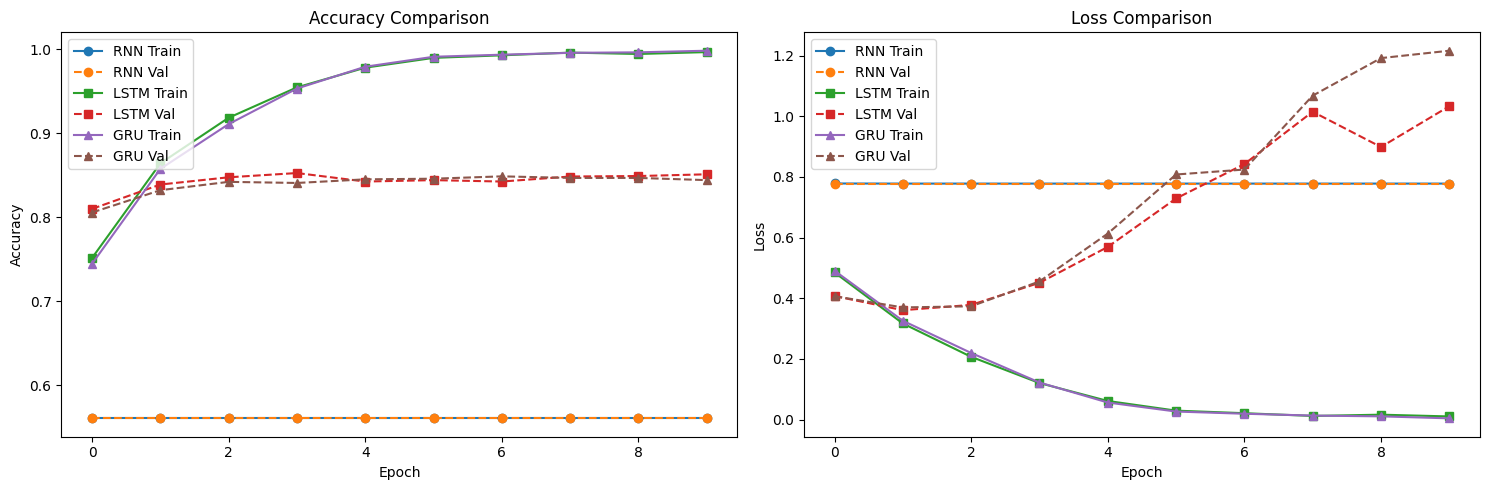

In [38]:
# Visualisasi perbandingan model
print("\nVisualisasi perbandingan model...")
plot_comparison(rnn_results, lstm_results, gru_results)

In [39]:
# Fungsi untuk mencoba prediksi dengan kalimat baru
def predict_sarcasm(model, text):
    """Prediksi apakah sebuah teks mengandung sarkasme"""
    # Tokenisasi dan padding teks
    seq = tokenizer.texts_to_sequences([text])
    padded = pad_sequences(seq, maxlen=30, padding='post')

    # Konversi ke tensor dan prediksi
    tensor = torch.tensor(padded, dtype=torch.long).to(device)
    model.eval()
    with torch.no_grad():
        pred = model(tensor)

    prob = pred.item()
    is_sarcastic = prob >= 0.5

    return {
        'text': text,
        'probability': prob,
        'is_sarcastic': is_sarcastic,
        'prediction': "Sarkasme" if is_sarcastic else "Bukan Sarkasme"
    }

In [40]:
# Uji model dengan beberapa kalimat baru
test_headlines = [
    "scientists discover new species of animal that can survive nuclear explosion",
    "new study shows coffee may help you live longer",
    "local man decides to try diet and exercise before complaining about weight",
    "politicians agree to put aside differences and work for common good"
]

In [41]:
# Gunakan model GRU untuk prediksi (bisa ganti dengan model lain)
print("\nUji model GRU dengan beberapa headline baru:")
for headline in test_headlines:
    result = predict_sarcasm(gru_model, headline)
    print(f"Headline: '{result['text']}'")
    print(f"Prediksi: {result['prediction']} (Probabilitas: {result['probability']:.4f})")
    print()


Uji model GRU dengan beberapa headline baru:
Headline: 'scientists discover new species of animal that can survive nuclear explosion'
Prediksi: Sarkasme (Probabilitas: 1.0000)

Headline: 'new study shows coffee may help you live longer'
Prediksi: Sarkasme (Probabilitas: 0.9928)

Headline: 'local man decides to try diet and exercise before complaining about weight'
Prediksi: Sarkasme (Probabilitas: 1.0000)

Headline: 'politicians agree to put aside differences and work for common good'
Prediksi: Sarkasme (Probabilitas: 0.9951)

